In [1]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
from numpy import nan
from numpy import absolute

import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.graphics.regressionplots import *
from yellowbrick.regressor import CooksDistance

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler

from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet, SGDRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from xgboost.sklearn import XGBRegressor

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import RandomizedSearchCV


import os

In [2]:
df = pd.read_csv("compresive_strength_concrete.csv")
print('Dataset Shape:{}'.format(df.shape))
df.head()

Dataset Shape:(1030, 9)


,Cement (component 1)(kg in a m^3 mixture),Blast Furnace Slag (component 2)(kg in a m^3 mixture),Fly Ash (component 3)(kg in a m^3 mixture),Water (component 4)(kg in a m^3 mixture),Superplasticizer (component 5)(kg in a m^3 mixture),Coarse Aggregate (component 6)(kg in a m^3 mixture),Fine Aggregate (component 7)(kg in a m^3 mixture),Age (day),"Concrete compressive strength(MPa, megapascals)"
0,540.0,0.0,0.0,162.0,2.5,1040.0,676.0,28,79.99
1,540.0,0.0,0.0,162.0,2.5,1055.0,676.0,28,61.89
2,332.5,142.5,0.0,228.0,0.0,932.0,594.0,270,40.27
3,332.5,142.5,0.0,228.0,0.0,932.0,594.0,365,41.05
4,198.6,132.4,0.0,192.0,0.0,978.4,825.5,360,44.30


In [3]:
df.columns = ["Cement", "BlastFurnaceSlag", "FlyAsh", "Water", "Superplasticizer",
              "CoarseAggregate", "FineAggregare", "Age", "CC_Strength"]

print(df.isnull().sum())

Cement              0
BlastFurnaceSlag    0
FlyAsh              0
Water               0
Superplasticizer    0
CoarseAggregate     0
FineAggregare       0
Age                 0
CC_Strength         0
dtype: int64


In [4]:
df.describe()

,Cement,BlastFurnaceSlag,FlyAsh,Water,Superplasticizer,CoarseAggregate,FineAggregare,Age,CC_Strength
count,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000
mean,281.167864,73.895825,54.188350,181.567282,6.204660,972.918932,773.580485,45.662136,35.817961
std,104.506364,86.279342,63.997004,21.354219,5.973841,77.753954,80.175980,63.169912,16.705742
min,102.000000,0.000000,0.000000,121.800000,0.000000,801.000000,594.000000,1.000000,2.330000
25%,192.375000,0.000000,0.000000,164.900000,0.000000,932.000000,730.950000,7.000000,23.710000
50%,272.900000,22.000000,0.000000,185.000000,6.400000,968.000000,779.500000,28.000000,34.445000
75%,350.000000,142.950000,118.300000,192.000000,10.200000,1029.400000,824.000000,56.000000,46.135000
max,540.000000,359.400000,200.100000,247.000000,32.200000,1145.000000,992.600000,365.000000,82.600000


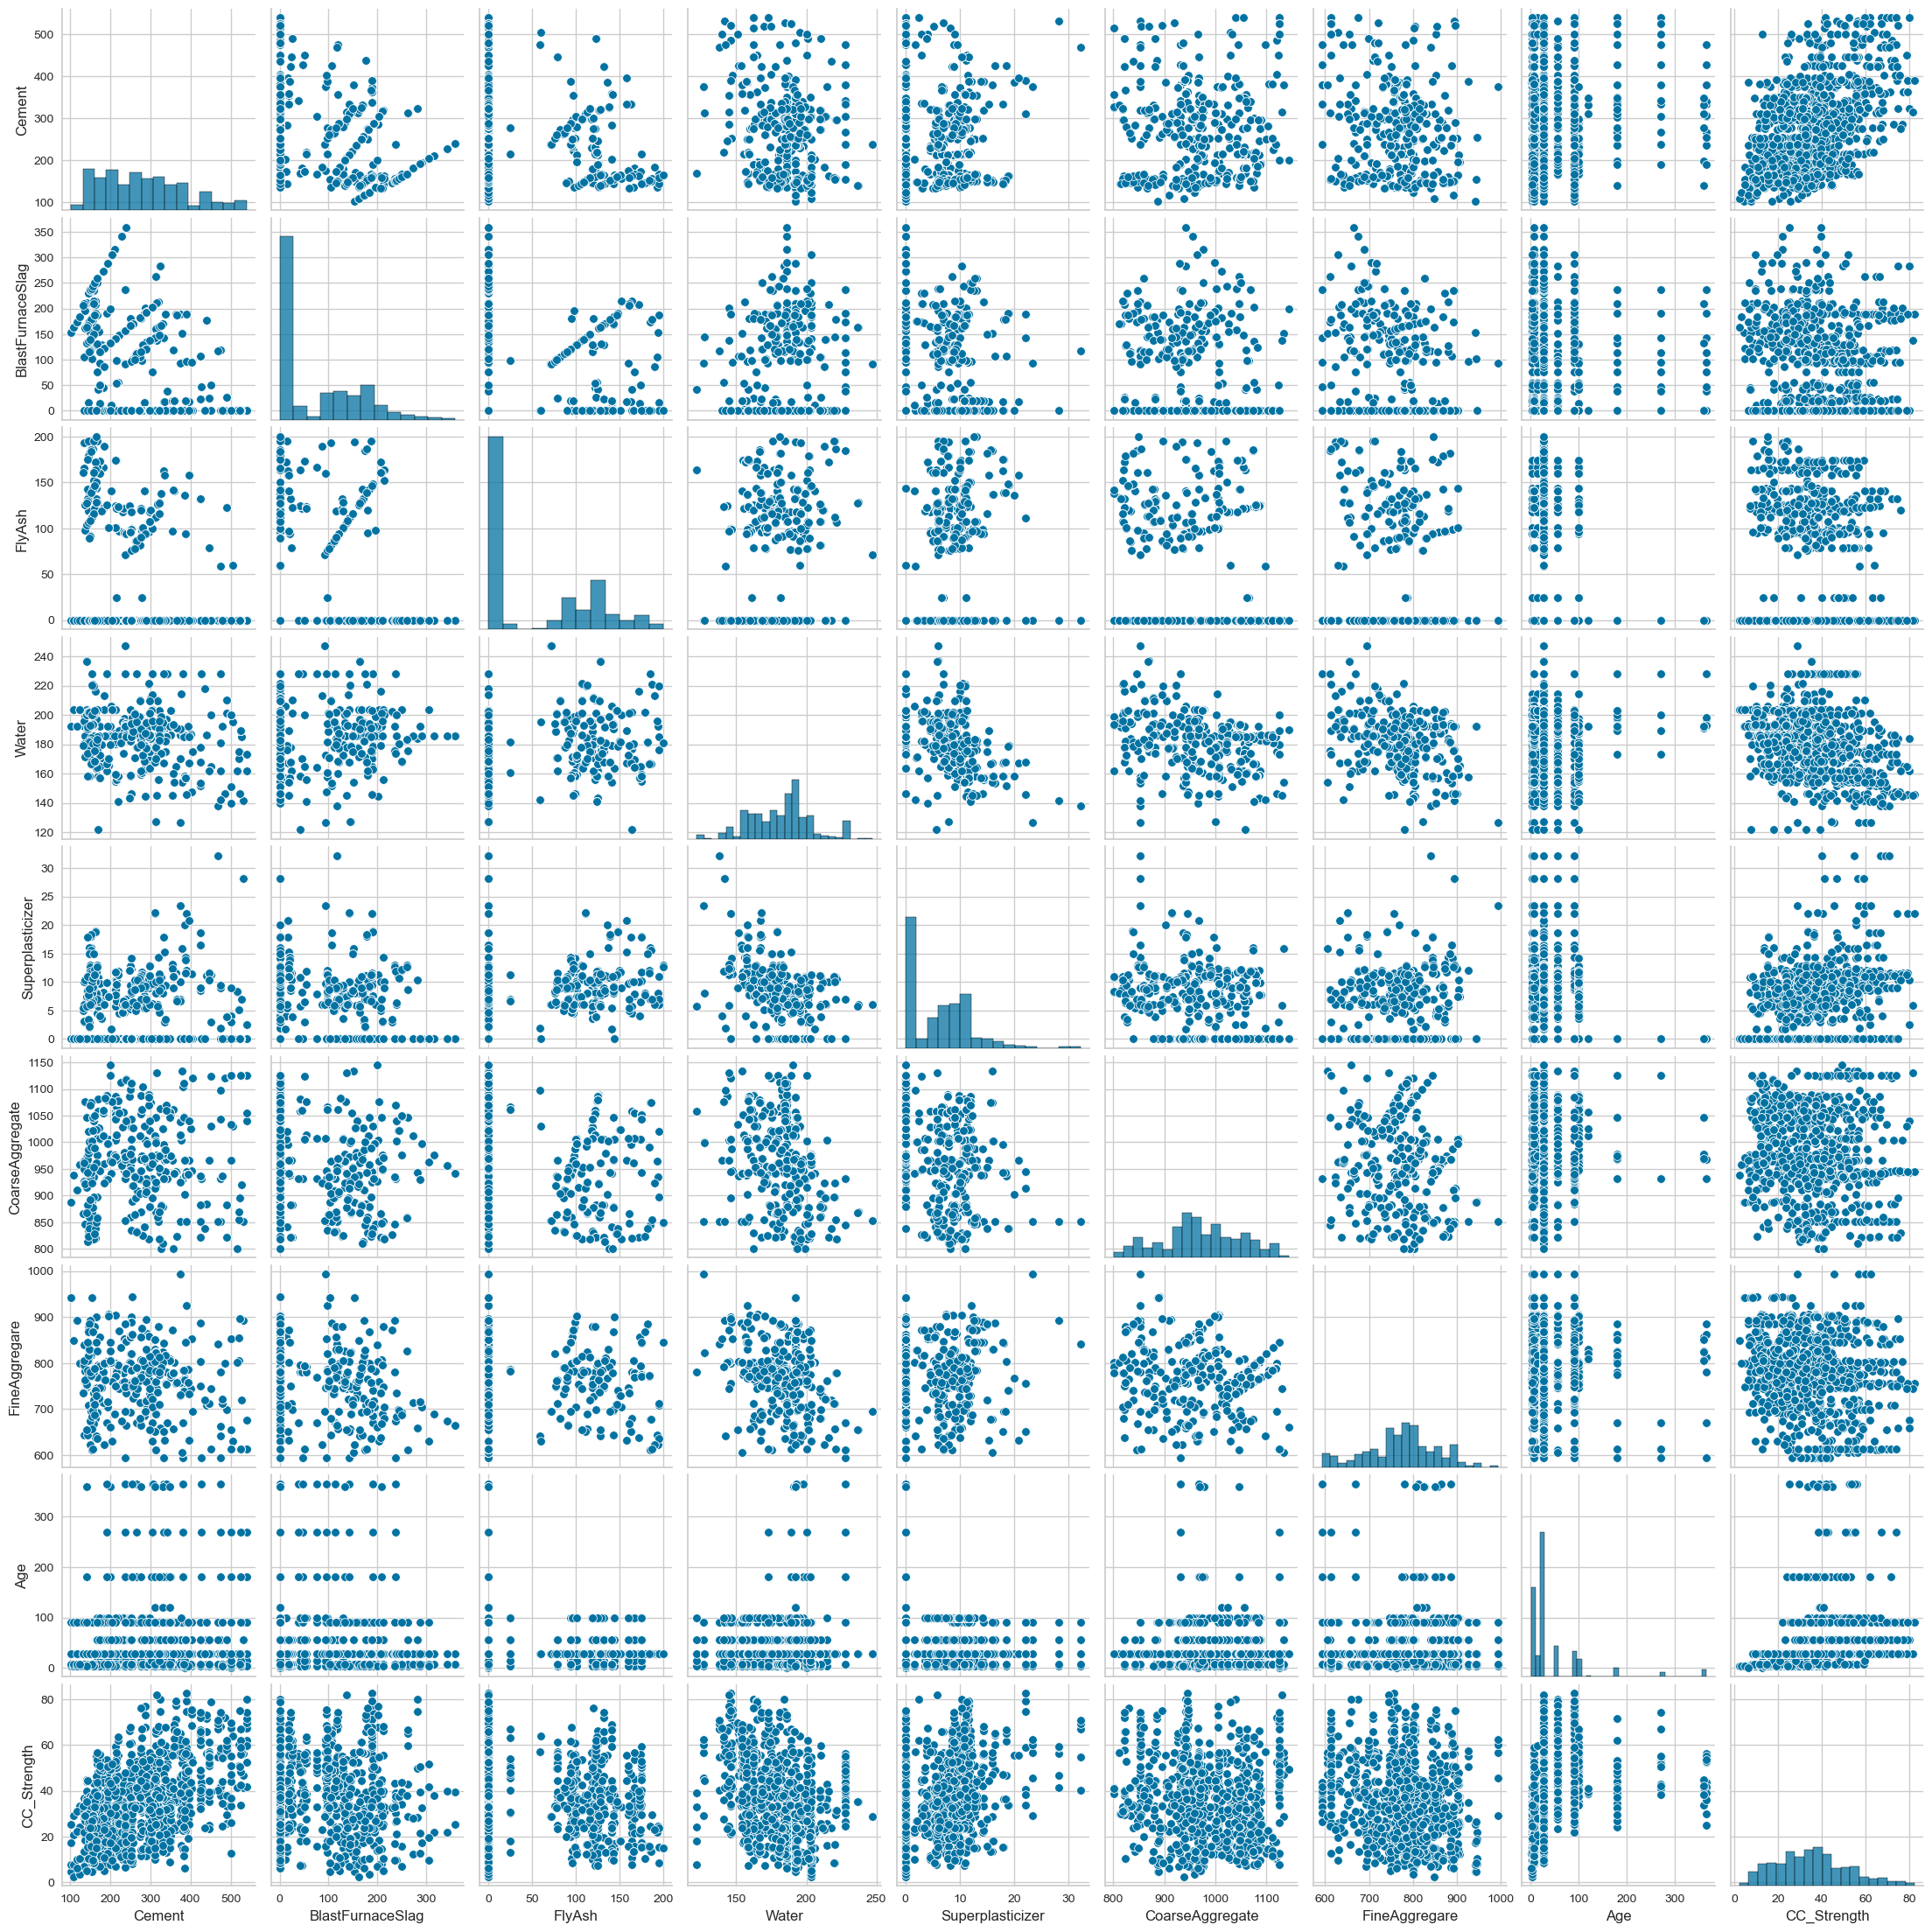

In [5]:
sns.pairplot(df)

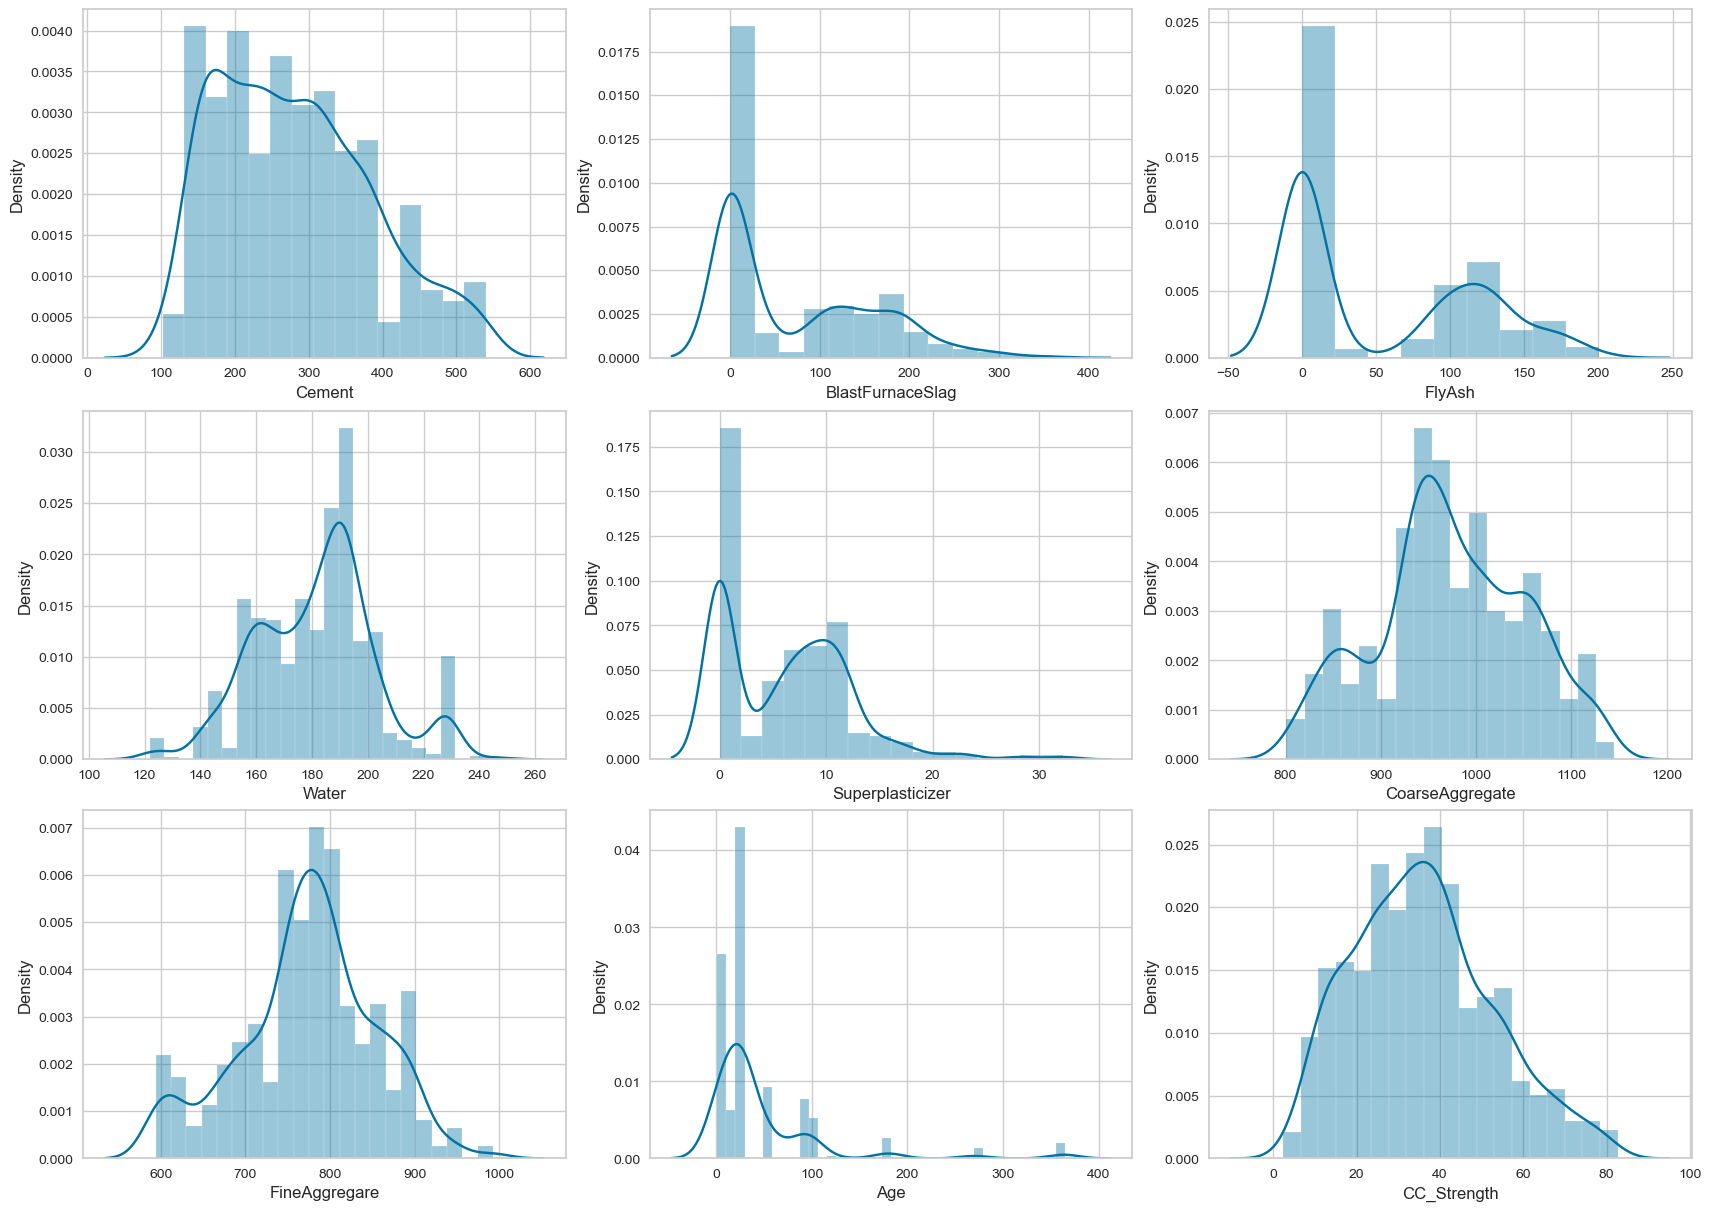

In [6]:
fig, ax = plt.subplots(3,3, figsize=(17,12), constrained_layout=True)
ax=ax.flatten()
sns.set_style("darkgrid")
for num, col in enumerate(df.columns):
    sns.distplot(df[col], ax=ax[num])
plt.show()


<Axes: >

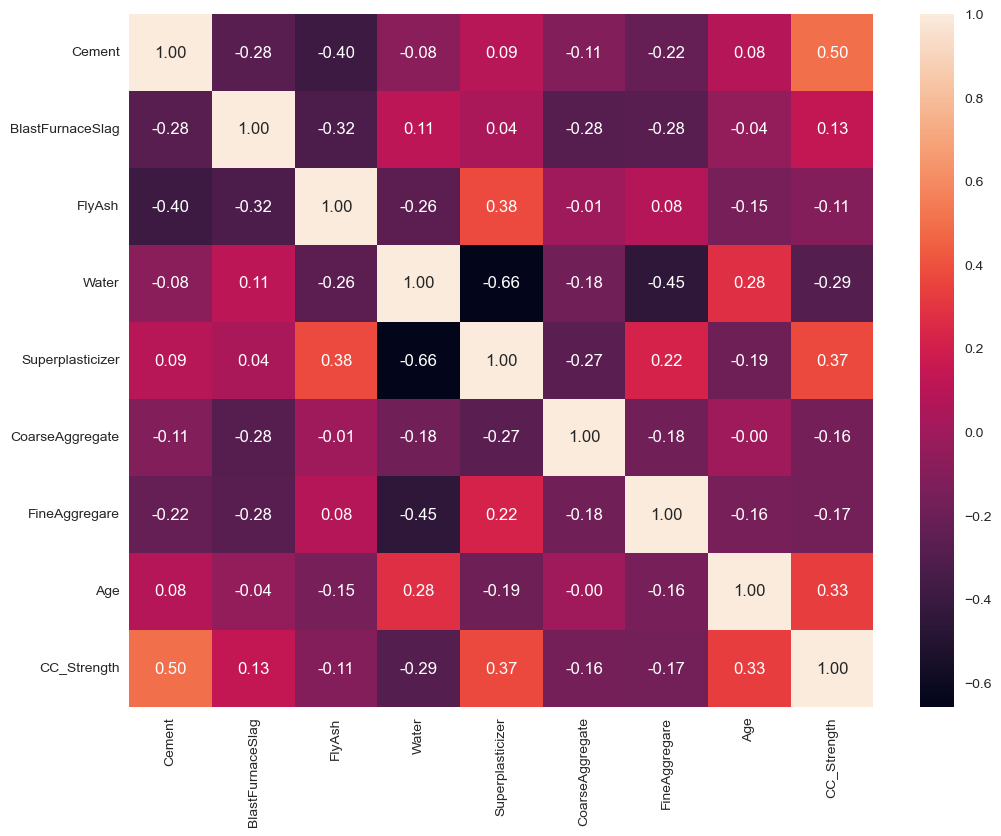

In [7]:
plt.figure(figsize=(12,9))
sns.heatmap(df.corr(), annot=True, fmt='.2f')

In [8]:
correlation_unstakced = df.corr().unstack().sort_values(ascending = False)
correlation_unstakced = correlation_unstakced[correlation_unstakced != 1]
correlation_unstakced = np.round(correlation_unstakced, 2)
correlation_unstakced.head(10)

CC_Strength       Cement              0.50
Cement            CC_Strength         0.50
FlyAsh            Superplasticizer    0.38
Superplasticizer  FlyAsh              0.38
CC_Strength       Superplasticizer    0.37
Superplasticizer  CC_Strength         0.37
CC_Strength       Age                 0.33
Age               CC_Strength         0.33
                  Water               0.28
Water             Age                 0.28
dtype: float64

In [9]:
#Concrete Strength has high positive correlation with Cement (0.50), Superplasticizer (0.37), and Age (0.33)#

#Concrete Strength has high positive correlation with Water (-0.29)#

<Axes: xlabel='Cement', ylabel='CC_Strength'>

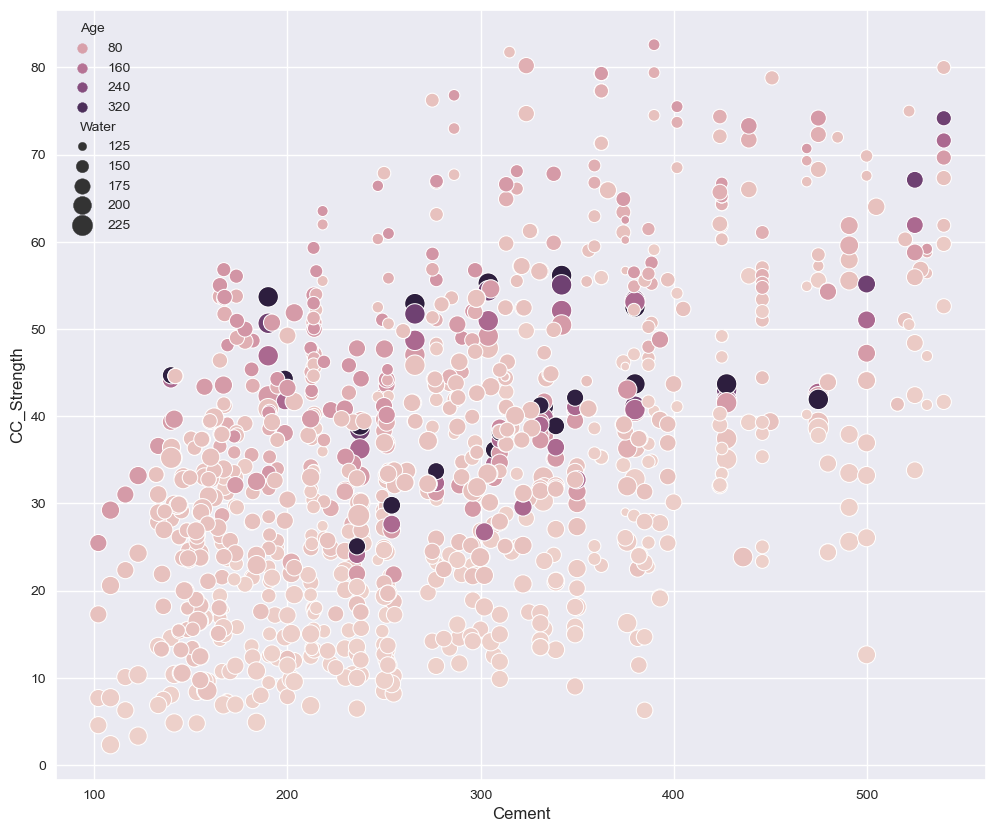

In [10]:
fig, ax = plt.subplots(figsize = (12, 10))
sns.scatterplot(data = df, y = 'CC_Strength', x = 'Cement', hue = 'Age', size = 'Water', 
                ax = ax, sizes = (30, 250))

In [11]:
X = df.iloc[:,:-1]
y = df.iloc[:,-1]

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((772, 8), (258, 8), (772,), (258,))

In [12]:
model = sm.OLS(y_train, sm.add_constant(X_train)).fit()   # To create a model 
model_summary = model.summary()
print(model_summary)


                            OLS Regression Results                            
Dep. Variable:            CC_Strength   R-squared:                       0.610
Model:                            OLS   Adj. R-squared:                  0.606
Method:                 Least Squares   F-statistic:                     149.1
Date:                Fri, 26 May 2023   Prob (F-statistic):          2.30e-150
Time:                        02:30:59   Log-Likelihood:                -2909.1
No. Observations:                 772   AIC:                             5836.
Df Residuals:                     763   BIC:                             5878.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const              -44.0299     29.944  

In [23]:
influence = model.get_influence()
influence_summary = influence.summary_frame()
print(influence_summary)


studentized_residuals = influence.resid_studentized_external   

(cooks, p) = influence.cooks_distance

(dffits, p) = influence.dffits 





     dfb_const  dfb_Cement  dfb_BlastFurnaceSlag  dfb_FlyAsh  dfb_Water  \
221   0.002577   -0.001600             -0.001963   -0.005863  -0.001300   
235   0.033219   -0.006396             -0.016348    0.000758  -0.034313   
547   0.002833   -0.002233             -0.003559   -0.003199  -0.002107   
499  -0.051904    0.068135              0.054412    0.066700   0.049753   
595   0.001539    0.008474             -0.001035    0.009482   0.001428   
..         ...         ...                   ...         ...        ...   
87   -0.003342   -0.011921             -0.058736    0.016144   0.061374   
330   0.009329   -0.011701             -0.012182   -0.003890  -0.019872   
466   0.002499    0.000752              0.000112   -0.001525  -0.001441   
121  -0.042164    0.078265              0.059882    0.048239   0.036849   
860   0.010584   -0.007300             -0.010114   -0.004934  -0.009237   

     dfb_Superplasticizer  dfb_CoarseAggregate  dfb_FineAggregare   dfb_Age  \
221              0.0

In [18]:
influence_summary

,dfb_const,dfb_Cement,dfb_BlastFurnaceSlag,dfb_FlyAsh,dfb_Water,dfb_Superplasticizer,dfb_CoarseAggregate,dfb_FineAggregare,dfb_Age,cooks_d,standard_resid,hat_diag,dffits_internal,student_resid,dffits
221,0.002577,-0.001600,-0.001963,-0.005863,-0.001300,0.002467,-0.003716,-0.002256,0.000104,0.000018,-0.143004,0.007713,-0.012608,-0.142912,-0.012600
235,0.033219,-0.006396,-0.016348,0.000758,-0.034313,-0.038914,-0.043513,-0.023890,0.015668,0.000579,-0.854374,0.007092,-0.072205,-0.854223,-0.072192
547,0.002833,-0.002233,-0.003559,-0.003199,-0.002107,-0.002582,-0.003587,-0.001622,-0.002880,0.000006,0.082819,0.008299,0.007576,0.082766,0.007571
499,-0.051904,0.068135,0.054412,0.066700,0.049753,-0.007117,0.039258,0.049941,-0.004244,0.000696,0.397991,0.038058,0.079163,0.397771,0.079119
595,0.001539,0.008474,-0.001035,0.009482,0.001428,0.003427,-0.009919,0.000456,0.006127,0.000200,-0.508226,0.006915,-0.042409,-0.507979,-0.042389
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
87,-0.003342,-0.011921,-0.058736,0.016144,0.061374,0.014205,-0.025123,-0.012396,0.016076,0.005911,-2.304163,0.009920,-0.230642,-2.310706,-0.231297
330,0.009329,-0.011701,-0.012182,-0.003890,-0.019872,0.003214,0.003548,-0.010799,-0.001488,0.000377,0.630265,0.008465,0.058235,0.630016,0.058212
466,0.002499,0.000752,0.000112,-0.001525,-0.001441,-0.004361,-0.004559,-0.001509,-0.005976,0.000019,-0.139074,0.008720,-0.013044,-0.138984,-0.013035
121,-0.042164,0.078265,0.059882,0.048239,0.036849,-0.006142,0.018506,0.052277,-0.010750,0.001665,1.168903,0.010846,0.122399,1.169184,0.122429


In [20]:
y_df = pd.DataFrame(y_train, columns = ['CC_Strength'])
conc_y_df = pd.concat([y_df, influence_summary], axis = 1)
conc_y_df

,CC_Strength,dfb_const,dfb_Cement,dfb_BlastFurnaceSlag,dfb_FlyAsh,dfb_Water,dfb_Superplasticizer,dfb_CoarseAggregate,dfb_FineAggregare,dfb_Age,cooks_d,standard_resid,hat_diag,dffits_internal,student_resid,dffits
221,21.54,0.002577,-0.001600,-0.001963,-0.005863,-0.001300,0.002467,-0.003716,-0.002256,0.000104,0.000018,-0.143004,0.007713,-0.012608,-0.142912,-0.012600
235,17.84,0.033219,-0.006396,-0.016348,0.000758,-0.034313,-0.038914,-0.043513,-0.023890,0.015668,0.000579,-0.854374,0.007092,-0.072205,-0.854223,-0.072192
547,23.40,0.002833,-0.002233,-0.003559,-0.003199,-0.002107,-0.002582,-0.003587,-0.001622,-0.002880,0.000006,0.082819,0.008299,0.007576,0.082766,0.007571
499,55.55,-0.051904,0.068135,0.054412,0.066700,0.049753,-0.007117,0.039258,0.049941,-0.004244,0.000696,0.397991,0.038058,0.079163,0.397771,0.079119
595,17.60,0.001539,0.008474,-0.001035,0.009482,0.001428,0.003427,-0.009919,0.000456,0.006127,0.000200,-0.508226,0.006915,-0.042409,-0.507979,-0.042389
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
87,24.40,-0.003342,-0.011921,-0.058736,0.016144,0.061374,0.014205,-0.025123,-0.012396,0.016076,0.005911,-2.304163,0.009920,-0.230642,-2.310706,-0.231297
330,42.22,0.009329,-0.011701,-0.012182,-0.003890,-0.019872,0.003214,0.003548,-0.010799,-0.001488,0.000377,0.630265,0.008465,0.058235,0.630016,0.058212
466,33.56,0.002499,0.000752,0.000112,-0.001525,-0.001441,-0.004361,-0.004559,-0.001509,-0.005976,0.000019,-0.139074,0.008720,-0.013044,-0.138984,-0.013035
121,68.30,-0.042164,0.078265,0.059882,0.048239,0.036849,-0.006142,0.018506,0.052277,-0.010750,0.001665,1.168903,0.010846,0.122399,1.169184,0.122429


In [24]:
# Identity Outliers Manually
studentized_residual = concat_y_df.student_resid
concat_y_df.CC_Strength[abs(studentized_residual) >3]

381    81.75
383    78.80
Name: CC_Strength, dtype: float64